In [1]:
import os
import json
import argparse
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "scripts"))
from utils import basic_Q_features, ST_features

### Init

In [3]:
class Config:
    def __init__(self, args=None):
        self.setup_paths(args)

    def load_json(self, data: dict):
        self.__dict__.update({
            k.lower(): v for k, v in data.items()
        })

    def setup_paths(self, args):
        self.subj_data_path = os.path.join("..", "data", "meta", "subj_Q+ST.csv")
        ## Model results:
        self.result_dir = os.path.join("..", "models", args.folder)
        self.config_json_path = os.path.join(self.result_dir, "config.json")
        self.final_preds_path = os.path.join(self.result_dir, "final_predictions.csv")
        self.trainval_hist_path = os.path.join(self.result_dir, "train-val_history.csv")

In [4]:
def define_arguments(x):
    parser = argparse.ArgumentParser()
    parser.add_argument("-f", "--folder", type=str, required=True, 
                        help="Name of the folder containing the input files.")
    parser.add_argument("-o", "--overwrite", action="store_true", 
                        help="Overwrite output files if they already exist.")
    return parser.parse_args(args=x)

In [5]:
folder = ["2025-12-29_sfcn++", "2026-01-05_sfcn"][-1]
args = define_arguments(["-f", folder])
config = Config(args)
with open(config.config_json_path, 'r', errors='ignore') as f:
    config_json = json.load(f)
config.load_json(config_json)

In [ ]:
# vars(config)

### Load and merge dataframes

In [14]:
trainval_history = pd.read_csv(config.trainval_hist_path)
final_preds = pd.read_csv(config.final_preds_path)
final_preds.set_index("SID", inplace=True)
subj_data = pd.read_csv(config.subj_data_path)
subj_data.set_index("BASIC_INFO_ID", inplace=True)
merged_df = pd.merge(final_preds, subj_data, left_index=True, right_index=True)

### Aggregate mean absolute PAD values for each set

In [ ]:
# print("PAD\tPAD_ac")
# for s in ["Train", "Val", "Test"]:
#     dat = final_preds.query(f"Set == '{s}'")
#     print(f'{dat["PAD"].abs().mean():.3f}\t{dat["PAD_ac"].abs().mean():.3f}')

In [12]:
pd.merge(
    (final_preds
        .assign(PADAC_abs=final_preds["PAD_ac"].abs())
        .groupby(final_preds["Set"])["PADAC_abs"]
        .mean()
        .to_frame()
        .sort_index(key=lambda x: x.map({"Train": 0, "Val": 1, "Test": 2}))
    ), 
    (final_preds
        .assign(PAD_abs=final_preds["PAD"].abs())
        .groupby(final_preds["Set"])["PAD_abs"]
        .mean()
        .to_frame()
    ), 
    left_index=True, 
    right_index=True
)

,PADAC_abs,PAD_abs
Set,,
Train,6.941208,5.994814
Val,4.506356,4.898611
Test,5.264599,6.211105


### Plot correlations between chronological ages and PAD values

In [7]:
def sig_p(p):
    return f"{'< .001' if p < .001 else ('= ' + str(round(p, 4)).lstrip('0'))} {'*' * sum( p <= t for t in [0.05, 0.01, 0.001] )}"

In [8]:
def plot_corr_and_regress(DF, x_col, y_col, cat_col="Set", cat_list=["Train", "Val", "Test"], 
                          x_lim=(15, 85), x_ticks=np.arange(20, 85, 10), x_label=None, 
                          y_lim=(-50, 50), y_ticks=np.arange(-50, 50, 10), y_label=None, 
                          out_path=None, fig_size=(15, 5), overwrite=False):
    if not os.path.exists(out_path) or overwrite:
        sns.set(style="whitegrid", font_scale=1.5)
        fig = plt.figure(figsize=fig_size)
        nrows = len(cat_list) // 4 + 1
        ncols = len(cat_list) // nrows 

        for i, cat in enumerate(cat_list):
            cat_df = DF.query(f"{cat_col} == '{cat}'")
            x_val = cat_df[x_col].values
            y_val = cat_df[y_col].values
            r, p_r = stats.pearsonr(x_val, y_val)
            n = len(x_val)
            F = (r**2 / (1 - r**2)) * (n - 2)
            p_F = 1 - stats.f.cdf(F, 1, n-2)
            m, c = np.polyfit(x_val, y_val, 1)

            plt.subplot(nrows, ncols, i + 1)
            g = sns.regplot(
                data=cat_df, x=x_col, y=y_col, x_jitter=False, y_jitter=False, 
                scatter_kws={'s': 100, 'alpha': 0.5, 'edgecolor': 'white'}, line_kws={'linewidth': 1}
            )
            g.set(
                xlim=x_lim, ylim=y_lim, xticks=x_ticks, yticks=y_ticks, 
                xlabel="", ylabel="", title=cat
            )
            g.axhline(0, color="r", linewidth=1, linestyle="--")
            g.text(
                0.5, 0.9, f"$r$ = {r:.2f}, $p$ {sig_p(p_r)}, N = {n}", 
                transform=g.transAxes, ha="center", linespacing=1.5, fontsize=16
            )
            g.text(
                0.5, 0.05, f"y = {c:.2f} + {m:.2f}x\n$F$({1}, {n-2}) = {F:.2f}, $p$ {sig_p(p_F)}", 
                transform=g.transAxes, ha="center", linespacing=1.5, fontsize=16
            )
        fig.tight_layout(rect=[0.02, 0, 1, 1])
        fig.supxlabel(x_label, fontsize=18)
        fig.supylabel(y_label, fontsize=18)
        plt.show()

In [ ]:
# final_preds = pd.read_csv(config.final_preds_path)

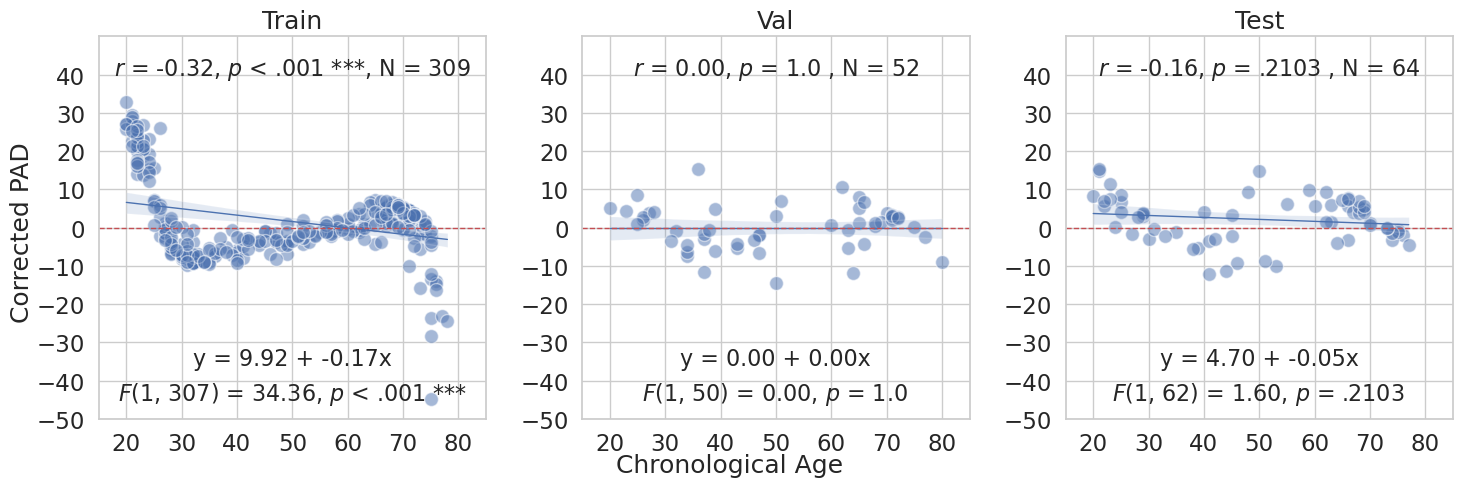

In [9]:
plot_corr_and_regress(
    DF=final_preds, 
    x_col="True_Age", 
    y_col=["PAD", "PAD_ac"][-1], 
    x_label="Chronological Age", 
    y_label=["Raw PAD", "Corrected PAD"][-1], 
    out_path="", 
    overwrite=args.overwrite
)

### Plot correlations between PAD values and ST/Q features

In [13]:
basic_q_features = basic_Q_features()
st_features = ST_features()

In [15]:
def plot_cormat_by_set(DF, targ_col, y_cols, y_label=None,
                       cat_col="Set", cat_list=["Train", "Val", "Test"], 
                       out_path=None, fig_size=(10, 6), overwrite=False):
    assert out_path is not None, "Output path must be specified."
    if not os.path.exists(out_path) or overwrite:
        cormat = pd.DataFrame(index=y_cols, columns=cat_list, dtype=float)
        p_mat = cormat.copy(deep=True)
        for cat in cat_list:
            cat_df = DF.query(f"{cat_col} == '{cat}'")
            for col in y_cols:
                targ_df = cat_df.loc[:, [targ_col, col]].dropna()
                cormat.loc[col, cat], p_mat.loc[col, cat] = stats.pearsonr(targ_df[targ_col].values, targ_df[col].values)
        p_sig = p_mat.map(lambda x: "*" * sum( x <= t for t in [0.05, 0.01, 0.001] ))
        annot_mat = cormat.map(lambda x: f"{x:.2f}") + p_sig

        sns.set_theme(style="white", font_scale=1.1)
        plt.figure(figsize=fig_size)
        g = sns.heatmap(
            cormat, mask=None, square=False, 
            vmin=-1, vmax=1, linewidth=.5, cmap="RdBu_r", cbar=False, 
            annot=pd.DataFrame(annot_mat), fmt = "", annot_kws={"size": 20}
        )
        g.set(xlabel="", ylabel="")
        g.tick_params(axis="both", which="major", labelsize=20)
        plt.tight_layout()
        plt.show()

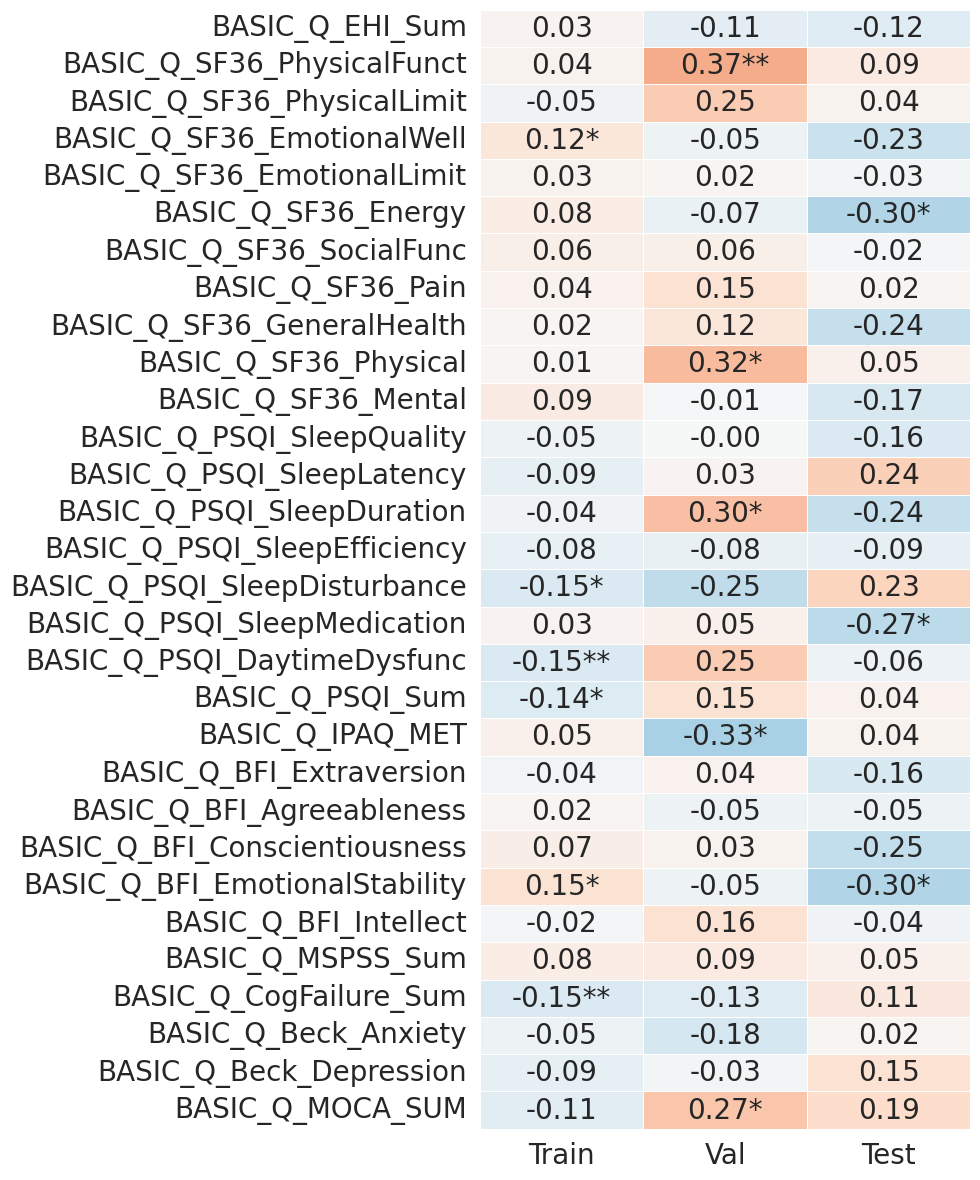

In [17]:
plot_cormat_by_set(
    DF=merged_df, 
    targ_col="PAD", 
    y_cols=basic_q_features, 
    out_path="", 
    fig_size=(10, 12), 
    overwrite=args.overwrite
)

### Plot loss changes during training

In [10]:
def plot_trainval_history(DF, col, config, out_path, fold_start=1, fold_end=None, 
                          title=None, x_label=None, y_label=None, fig_size=(10, 5), overwrite=False):
    if not os.path.exists(out_path) or overwrite:
        fold_end = config.k_folds + 1 if fold_end is None else fold_end
        # plt.style.use("seaborn-v0_8-white")
        fig = plt.figure(figsize=fig_size)
        for fold_n in range(fold_start, fold_end):
            epochs = np.arange(1, config.num_epochs + 1)
            losses = DF.query(f"fold == {fold_n}")[col].values
            plt.plot(epochs, losses, label=f"Fold {fold_n}")
        plt.gca().spines[["right", "top"]].set_visible(False)
        plt.grid(False)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
# trainval_history = pd.read_csv(trainval_hist_path)

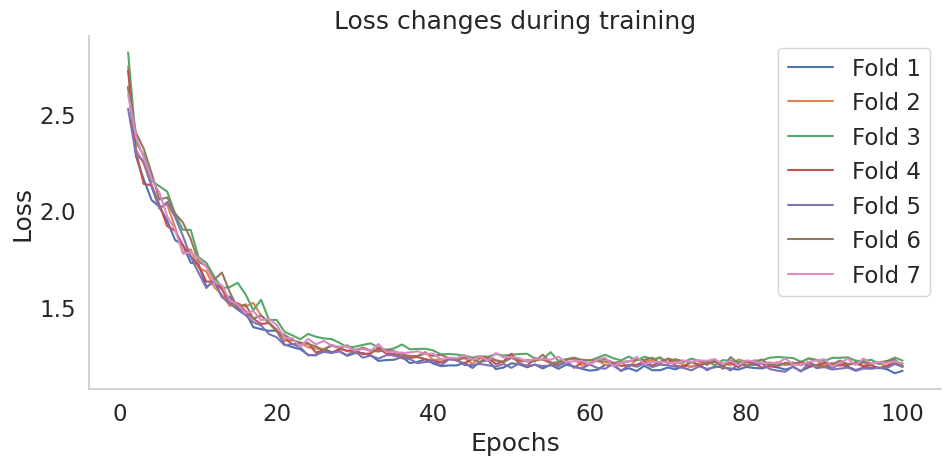

In [11]:
plot_trainval_history(
    DF=trainval_history, 
    col="train_loss", 
    config=config, 
    out_path="", 
    title="Loss changes during training", 
    x_label="Epochs", 
    y_label="Loss"
)